In [1]:
%matplotlib inline

In [1]:
from IPython.display import HTML
from lxml import etree
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.collections import PatchCollection
import matplotlib.font_manager as fm
from mpl_toolkits.basemap import Basemap
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon, shape, mapping
from shapely.prepared import prep
from pysal.esda.mapclassify import Natural_Breaks as nb
from descartes import PolygonPatch
import mpl_toolkits.basemap.pyproj as pyproj
import fiona
from itertools import chain

In [2]:
# folium stuff
import json
import folium

In [3]:
# ensure we have Helvetica available
fm.findSystemFonts(fontpaths='/users/sth/fonts', fontext='ttf')
prop = fm.FontProperties(fname='/users/sth/fonts/helvetica.ttf')

# Parse an XML file into a dict

In [4]:
# parse XML into dict
tree = etree.parse("data/plaques_20140619.xml")
root = tree.getroot()

output = dict()
output['raw'] = []
output['crs'] = []
output['lon'] = []
output['lat'] = []

for each in root.xpath('/openplaques/plaque/geo'):
    # check what we got back
    output['crs'].append(each.get('reference_system', None))
    output['lon'].append(each.get('longitude', None))
    output['lat'].append(each.get('latitude', None))
    # now go back up to plaque
    r = each.getparent().xpath('inscription/raw')[0]
    if isinstance(r.text, str):
        output['raw'].append(r.text.lstrip().rstrip())
    else:
        output['raw'].append(None)

# Set up a DataFrame, and perform type conversion(s)

In [5]:
df = pd.DataFrame(output)
df = df.replace({'raw': 0}, None)
df = df.dropna()
df[['lon', 'lat']] = df[['lon', 'lat']].astype(float)

# Get GeoJSON data, and create bounds, width and height

In [6]:
shp = fiona.open('data/wards.geojson')
crs_data = shp.crs
bds = shp.bounds
shp.close()
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

# Create a Basemap instance, and open the shapefile

(649,
 5,
 [-0.5103750689005356, 51.28676016315085, 0.0, 0.0],
 [0.3340155643740321, 51.691874116909894, 0.0, 0.0],
 <matplotlib.collections.LineCollection at 0x10dd58550>)

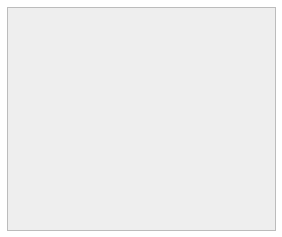

In [7]:
m = Basemap(
    projection='tmerc',
    lon_0 = -2.,
    lat_0 = 49.,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    lat_ts=0,
    resolution='i',
    suppress_ticks=True)
m.readshapefile(
    'data/london_wards',
    'london',
    color='none',
    zorder=2)

# Create a DataFrame holding ward polygons and area

In [8]:
# set up a map dataframe
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.london],
    'ward_name': [w['NAME'] for w in m.london_info],
})
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000

# Create Point objects in map coordinates from dataframe lon and lat values
map_points = pd.Series(
    [Point(m(mapped_x, mapped_y)) for mapped_x, mapped_y in zip(df['lon'], df['lat'])])
plaque_points = MultiPoint(list(map_points.values))
wards_polygon = prep(MultiPolygon(list(df_map['poly'].values)))
# calculate points that fall within the London boundary
ldn_points = filter(wards_polygon.contains, plaque_points)

# Calculate plaque density data and bins

In [9]:
# create a MultiPoint which we can check for set membership
df_map['count'] = df_map['poly'].map(lambda x: int(len(filter(prep(x).contains, ldn_points))))
df_map['density_m'] = df_map['count'] / df_map['area_m']
df_map['density_km'] = df_map['count'] / df_map['area_km']
# it's easier to work with NaN values when classifying
df_map.replace(to_replace={'density_m': {0: np.nan}, 'density_km': {0: np.nan}}, inplace=True)

In [10]:
# Calculate Jenks natural breaks for density
breaks = nb(
    df_map[df_map['density_km'].notnull()].density_km.values,
    initial=300,
    k=6)
# the notnull method lets us match indices when joining
jb = pd.DataFrame({'jenks_bins': breaks.yb}, index=df_map[df_map['density_km'].notnull()].index)
df_map = df_map.join(jb)
df_map.jenks_bins.fillna(-1, inplace=True)

# Use the [Folium](https://github.com/wrobstory/folium) library to impose a choropleth map onto an in-browser map (OSM, MapBox, Stamen etc.)

In [17]:
# In order to use custom maps, pass any of the following as a tiles keyword:
"""
-"OpenStreetMap"
-"MapQuest Open"
-"MapQuest Open Aerial"
-"Mapbox Bright" (Limited levels of zoom for free tiles)
-"Mapbox Control Room" (Limited levels of zoom for free tiles)
-"Stamen Terrain"
-"Stamen Toner"
-"Cloudmade" (Must pass API key)
-"Mapbox" (Must pass API key)
"""
# we're binding the dataframe ward_name column to the GeoJSON feature.properties.NAME value
# this will vary according to shapefile / GeoJSON
# the data to be displayed as choropleth comes from the second 'columns' entry
map_osm = folium.Map(
    location=[51.5, 0.],
    zoom_start=10,
    )
map_osm.geo_json(
    geo_path='wards.geojson',
    data=df_map,
    columns=['ward_name', 'density_km'],
    key_on='feature.properties.NAME',
    threshold_scale = breaks.bins,
    fill_color='BuPu', fill_opacity=0.75, line_opacity=0.2,
    legend_name='Density (km2)')
map_osm.create_map(path='ward_map.html')

In [18]:
HTML('<iframe src=ward_map.html width=800 height=550></iframe>')